# Experiment 07: Attention U-Net + RAovSeg + Focal Tversky with Ovary-Side Masking (Model 7)

In the previous experiments, we observed that:

- Many slices appear to show **both ovaries**, but the ground-truth mask almost always labels **only one**.
- Our models (especially Model 5) often segment **two ovary-like blobs** or the **contralateral ovary**, which is anatomically reasonable but penalised by the Dice score.

This suggests a mismatch between the **data** (two visible ovaries) and the **labels** (one annotated ovary per slice). To reduce this source of label noise, we now run an additional experiment where we **hide the unlabeled side of the image** during training:

- For each slice, we use the ground-truth mask to locate the annotated ovary.
- We compute its horizontal centroid.
- If the ovary is on the left half of the image, we **zero out the right half** of the input image.
- If it is on the right half, we **zero out the left half**.

This ensures that, during training, the model **never sees an unlabeled second ovary** on the opposite side. At validation time, we keep the images unmasked so that evaluation is directly comparable to Model 5.

We reuse the same architecture and loss as Model 5:

- **Attention U-Net** with RAovSeg-style preprocessing
- **FocalTverskyLoss** (α = 0.7, β = 0.3, γ = 4/3)

and train a new model:

> **Model 7** = Attention U-Net + RAovSeg preprocessing + Focal Tversky + *ovary-side masking (training only)*.


In [1]:
# --- Imports and setup ---

import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

# Make sure we can import from src/
project_root = os.path.abspath(".")
if not os.path.exists(os.path.join(project_root, "src")):
    project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root:", project_root)

from src.data_loader import UterusDatasetWithPreprocessing
from src.models import AttentionUNet
from src.losses import FocalTverskyLoss

# --- Configuration ---

manifest_path = os.path.join(project_root, "data", "d2_manifest_t2fs_ovary_eligible.csv")
image_size = 256
batch_size = 1
num_epochs = 30  # you can bump to 40–50 if you have time

lr = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- Wrapped dataset with ovary-side masking (training only) ---

class UterusDatasetWithPreprocessingMasked(Dataset):
    """
    Wraps UterusDatasetWithPreprocessing and, optionally, masks out
    the half of the image opposite to the annotated ovary.

    - If ovary centroid is on the left half: zero-out right half.
    - If ovary centroid is on the right half: zero-out left half.
    - If no ovary in the mask: leave image unchanged.
    """

    def __init__(self, base_dataset: UterusDatasetWithPreprocessing, apply_mask: bool = True):
        self.base = base_dataset
        self.apply_mask = apply_mask

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        image, mask = self.base[idx]  # image: (1, H, W), mask: (1, H, W)

        if not self.apply_mask:
            return image, mask

        # Find ovary pixels in mask
        coords = torch.nonzero(mask[0] > 0, as_tuple=False)
        if coords.numel() == 0:
            # No annotated ovary -> do nothing
            return image, mask

        # Compute centroid along width dimension (x coordinate)
        cx = coords[:, 1].float().mean()
        width = image.shape[2]
        mid = width / 2.0

        image = image.clone()  # avoid in-place changes on underlying dataset

        if cx < mid:
            # Ovary on left -> zero right half
            image[:, :, int(mid):] = 0.0
        else:
            # Ovary on right -> zero left half
            image[:, :, :int(mid)] = 0.0

        return image, mask


Project root: c:\Users\lytten\programming\dlvr-project
Using device: cuda


In [2]:
# --- Base datasets with RAovSeg preprocessing ---

print("--- Loading Ovary Data with RAovSeg Preprocessing ---")
full_dataset = UterusDatasetWithPreprocessing(
    manifest_path=manifest_path, image_size=image_size, augment=True
)
val_full_dataset = UterusDatasetWithPreprocessing(
    manifest_path=manifest_path, image_size=image_size, augment=False
)

# --- Split by patient ID (same logic as other experiments) ---

patient_ids = full_dataset.manifest["patient_id"].unique()
split_idx = int(len(patient_ids) * 0.8)
train_ids, val_ids = patient_ids[:split_idx], patient_ids[split_idx:]

train_indices = [
    i for i, sm in enumerate(full_dataset.slice_map)
    if full_dataset.manifest.loc[sm["patient_index"], "patient_id"] in train_ids
]
val_indices = [
    i for i, sm in enumerate(val_full_dataset.slice_map)
    if val_full_dataset.manifest.loc[sm["patient_index"], "patient_id"] in val_ids
]

print(f"Training patients: {len(train_ids)}, Validation patients: {len(val_ids)}")
print(f"Training slices: {len(train_indices)}, Validation slices: {len(val_indices)}")

# --- Wrap datasets with masking for training only ---

train_base = full_dataset
val_base = val_full_dataset

train_dataset_masked = UterusDatasetWithPreprocessingMasked(train_base, apply_mask=True)
val_dataset_plain   = UterusDatasetWithPreprocessingMasked(val_base, apply_mask=False)

train_subset = Subset(train_dataset_masked, train_indices)
val_subset   = Subset(val_dataset_plain,   val_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train loader size: {len(train_loader)}, Val loader size: {len(val_loader)}")


--- Loading Ovary Data with RAovSeg Preprocessing ---
Loading manifest from c:\Users\lytten\programming\dlvr-project\data\d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the ovary.
Loading manifest from c:\Users\lytten\programming\dlvr-project\data\d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the ovary.
Training patients: 44, Validation patients: 12
Training slices: 214, Validation slices: 64
Train loader size: 214, Val loader size: 64


In [3]:
# --- Training utilities ---

def dice_score(preds, targets, epsilon=1e-6):
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    return (2.0 * intersection + epsilon) / (preds_flat.sum() + targets_flat.sum() + epsilon)


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(loader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            dice = dice_score(preds, masks)
            running_loss += loss.item() * images.size(0)
            running_dice += dice.item() * images.size(0)
    return running_loss / len(loader.dataset), running_dice / len(loader.dataset)



Epoch 1/30


  Train Loss: 0.9621 | Val Loss: 0.9419 | Val Dice: 0.1643
  -> New BEST model saved (epoch 1, Val Dice=0.1643)

Epoch 2/30


  Train Loss: 0.9400 | Val Loss: 0.9462 | Val Dice: 0.0783

Epoch 3/30


  Train Loss: 0.9107 | Val Loss: 0.9161 | Val Dice: 0.1271

Epoch 4/30


  Train Loss: 0.8611 | Val Loss: 0.9067 | Val Dice: 0.1118

Epoch 5/30


  Train Loss: 0.8002 | Val Loss: 0.8441 | Val Dice: 0.2072
  -> New BEST model saved (epoch 5, Val Dice=0.2072)

Epoch 6/30


  Train Loss: 0.7198 | Val Loss: 0.8577 | Val Dice: 0.1530

Epoch 7/30


  Train Loss: 0.6657 | Val Loss: 0.9171 | Val Dice: 0.0827

Epoch 8/30


  Train Loss: 0.5935 | Val Loss: 0.8426 | Val Dice: 0.1450

Epoch 9/30


  Train Loss: 0.5650 | Val Loss: 0.7561 | Val Dice: 0.2368
  -> New BEST model saved (epoch 9, Val Dice=0.2368)

Epoch 10/30


  Train Loss: 0.4957 | Val Loss: 0.8553 | Val Dice: 0.1419

Epoch 11/30


  Train Loss: 0.4964 | Val Loss: 0.7669 | Val Dice: 0.2237

Epoch 12/30


  Train Loss: 0.4683 | Val Loss: 0.7637 | Val Dice: 0.2248

Epoch 13/30


  Train Loss: 0.4584 | Val Loss: 0.7351 | Val Dice: 0.2514
  -> New BEST model saved (epoch 13, Val Dice=0.2514)

Epoch 14/30


  Train Loss: 0.4607 | Val Loss: 0.7774 | Val Dice: 0.2139

Epoch 15/30


  Train Loss: 0.4249 | Val Loss: 0.7654 | Val Dice: 0.2239

Epoch 16/30


  Train Loss: 0.4530 | Val Loss: 0.6825 | Val Dice: 0.2958
  -> New BEST model saved (epoch 16, Val Dice=0.2958)

Epoch 17/30


  Train Loss: 0.4421 | Val Loss: 0.7164 | Val Dice: 0.2665

Epoch 18/30


  Train Loss: 0.4432 | Val Loss: 0.6566 | Val Dice: 0.3139
  -> New BEST model saved (epoch 18, Val Dice=0.3139)

Epoch 19/30


  Train Loss: 0.4241 | Val Loss: 0.6785 | Val Dice: 0.2994

Epoch 20/30


  Train Loss: 0.4126 | Val Loss: 0.6747 | Val Dice: 0.2930

Epoch 21/30


  Train Loss: 0.4198 | Val Loss: 0.6704 | Val Dice: 0.2924

Epoch 22/30


  Train Loss: 0.3948 | Val Loss: 0.6626 | Val Dice: 0.3130

Epoch 23/30


  Train Loss: 0.3879 | Val Loss: 0.7822 | Val Dice: 0.2085

Epoch 24/30


  Train Loss: 0.3919 | Val Loss: 0.6950 | Val Dice: 0.2659

Epoch 25/30


  Train Loss: 0.3838 | Val Loss: 0.6704 | Val Dice: 0.3034

Epoch 26/30


  Train Loss: 0.3889 | Val Loss: 0.7594 | Val Dice: 0.2273

Epoch 27/30


  Train Loss: 0.3792 | Val Loss: 0.6834 | Val Dice: 0.2876

Epoch 28/30


  Train Loss: 0.3820 | Val Loss: 0.6972 | Val Dice: 0.2826

Epoch 29/30


  Train Loss: 0.3638 | Val Loss: 0.6804 | Val Dice: 0.2982

Epoch 30/30


  Train Loss: 0.3650 | Val Loss: 0.7036 | Val Dice: 0.2807

=== Finished training Model 7 (masked) ===
Best epoch: 18 with validation Dice = 0.3139
Model saved to: c:\Users\lytten\programming\dlvr-project\models\21_attn_unet_prep_ft_masked_best.pth


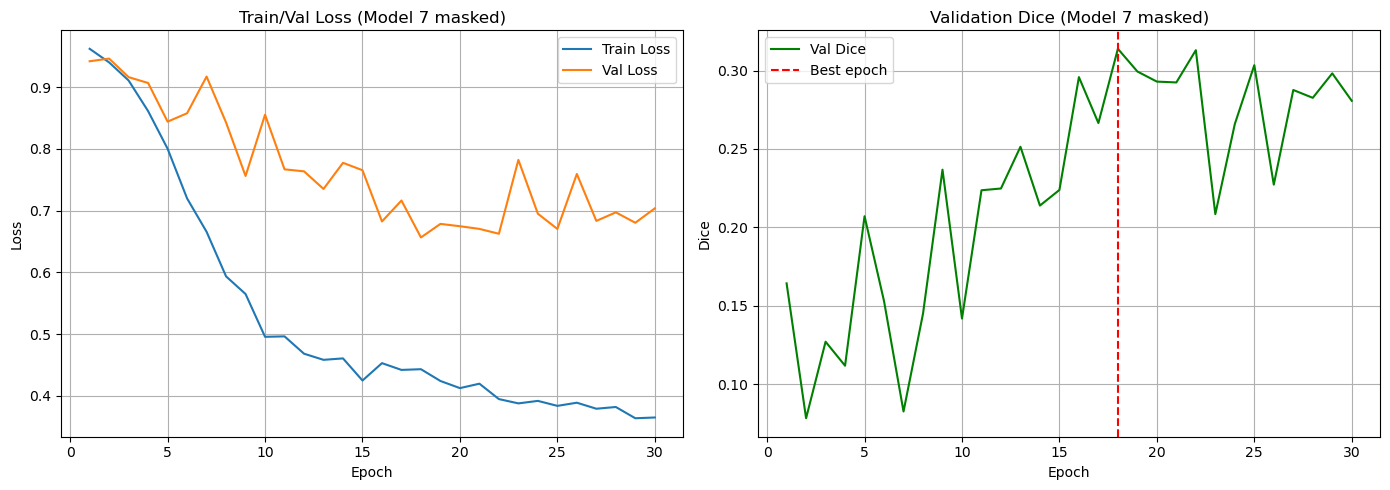

In [4]:
# --- Train Model 7: Attention U-Net + RAovSeg + Focal Tversky + ovary-side masking ---

model7 = AttentionUNet(n_channels=1, n_classes=1).to(device)
criterion = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=4/3)
optimizer = Adam(model7.parameters(), lr=lr)

train_loss_history = []
val_loss_history = []
val_dice_history = []

best_val_dice = -1.0
best_epoch = -1
model7_path = os.path.join(project_root, "models", "21_attn_unet_prep_ft_masked_best.pth")
os.makedirs(os.path.dirname(model7_path), exist_ok=True)

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss = train_one_epoch(model7, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(model7, val_loader, criterion, device)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_dice_history.append(val_dice)

    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

    if val_dice > best_val_dice:
        best_val_dice = val_dice
        best_epoch = epoch
        torch.save(model7.state_dict(), model7_path)
        print(f"  -> New BEST model saved (epoch {best_epoch}, Val Dice={best_val_dice:.4f})")

print("\n=== Finished training Model 7 (masked) ===")
print(f"Best epoch: {best_epoch} with validation Dice = {best_val_dice:.4f}")
print(f"Model saved to: {model7_path}")

# Plot training curves
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Val Loss (Model 7 masked)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_dice_history, label="Val Dice", color="green")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.title("Validation Dice (Model 7 masked)")
plt.axvline(x=best_epoch, color="red", linestyle="--", label="Best epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
# --- Optional: Compare Model 7 vs Model 5 on the same validation set ---

from src.models import AttentionUNet as AttnUNetPlain

models_dir = os.path.join(project_root, "models")
model5_path = os.path.join(models_dir, "15_attn_unet_focal_tversky_best.pth")

# Load Model 5
model5 = AttnUNetPlain(n_channels=1, n_classes=1).to(device)
model5.load_state_dict(torch.load(model5_path, map_location=device))
model5.eval()

print("\nEvaluating original Model 5 (no masking)...")
val_loss5, val_dice5 = validate(model5, val_loader, criterion, device)
print(f"Model 5 -> Val Loss: {val_loss5:.4f}, Val Dice: {val_dice5:.4f}")

# Load best Model 7
model7_best = AttnUNetPlain(n_channels=1, n_classes=1).to(device)
model7_best.load_state_dict(torch.load(model7_path, map_location=device))
model7_best.eval()

print("\nEvaluating Model 7 (ovary-side masking during training)...")
val_loss7, val_dice7 = validate(model7_best, val_loader, criterion, device)
print(f"Model 7 -> Val Loss: {val_loss7:.4f}, Val Dice: {val_dice7:.4f}")



Evaluating original Model 5 (no masking)...


Model 5 -> Val Loss: 0.6575, Val Dice: 0.3090

Evaluating Model 7 (ovary-side masking during training)...


Model 7 -> Val Loss: 0.6566, Val Dice: 0.3139


In [6]:
# --- Datasets for qualitative comparison (plain + preprocessed) ---

from src.data_loader import UterusDataset
from src.RAovSeg_tools import postprocess_

# Plain MRI for visualization
val_full_plain = UterusDataset(
    manifest_path=manifest_path, image_size=image_size, augment=False
)

# Preprocessed MRI (what both models expect)
val_full_prep = UterusDatasetWithPreprocessing(
    manifest_path=manifest_path, image_size=image_size, augment=False
)

# Build validation indices by patient (same split as earlier)
patient_ids = val_full_plain.manifest["patient_id"].unique()
split_idx = int(len(patient_ids) * 0.8)
train_ids, val_ids = patient_ids[:split_idx], patient_ids[split_idx:]

val_indices = [
    i
    for i, sm in enumerate(val_full_plain.slice_map)
    if val_full_plain.manifest.loc[sm["patient_index"], "patient_id"] in val_ids
]

print(f"Validation slices for qualitative comparison: {len(val_indices)}")

# --- Load Model 5 and Model 7 ---

models_dir = os.path.join(project_root, "models")
model5_path = os.path.join(models_dir, "15_attn_unet_focal_tversky_best.pth")
model7_path = os.path.join(models_dir, "21_attn_unet_prep_ft_masked_best.pth")

from src.models import AttentionUNet

model5 = AttentionUNet(n_channels=1, n_classes=1).to(device)
model5.load_state_dict(torch.load(model5_path, map_location=device))
model5.eval()
print("Loaded Model 5 from:", model5_path)

model7_best = AttentionUNet(n_channels=1, n_classes=1).to(device)
model7_best.load_state_dict(torch.load(model7_path, map_location=device))
model7_best.eval()
print("Loaded Model 7 from:", model7_path)


Loading manifest from c:\Users\lytten\programming\dlvr-project\data\d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the uterus.
Loading manifest from c:\Users\lytten\programming\dlvr-project\data\d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the ovary.
Validation slices for qualitative comparison: 64
Loaded Model 5 from: c:\Users\lytten\programming\dlvr-project\models\15_attn_unet_focal_tversky_best.pth
Loaded Model 7 from: c:\Users\lytten\programming\dlvr-project\models\21_attn_unet_prep_ft_masked_best.pth


In [7]:
# --- Rank validation slices by Model 5 Focal Tversky loss ---

criterion_ft = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=4/3)

slice_losses = []

print("Computing Focal Tversky loss for Model 5 on validation slices...")

with torch.no_grad():
    for idx in val_indices:
        img_prep, mask = val_full_prep[idx]
        img_batch = img_prep.unsqueeze(0).to(device)
        mask_batch = mask.unsqueeze(0).to(device)

        logits = model5(img_batch)
        loss = criterion_ft(logits, mask_batch)

        slice_losses.append((idx, float(loss.item())))

slice_losses_sorted = sorted(slice_losses, key=lambda x: x[1])
print(f"Computed losses for {len(slice_losses_sorted)} slices.")

k = 10
k = min(k, len(slice_losses_sorted) // 2)

easiest = slice_losses_sorted[:k]
hardest = slice_losses_sorted[-k:]

print("Easiest losses:", [round(l, 4) for _, l in easiest])
print("Hardest losses:", [round(l, 4) for _, l in hardest])

ranked_indices = [idx for idx, _ in easiest] + [idx for idx, _ in hardest]
print(f"Using {len(ranked_indices)} slices (top {k} + bottom {k}) for the grid.")


Computing Focal Tversky loss for Model 5 on validation slices...
Computed losses for 64 slices.
Easiest losses: [0.0305, 0.0778, 0.0802, 0.0807, 0.0901, 0.0917, 0.0976, 0.101, 0.1162, 0.1735]
Hardest losses: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Using 20 slices (top 10 + bottom 10) for the grid.


Generating Model 5 vs Model 7 qualitative grid...


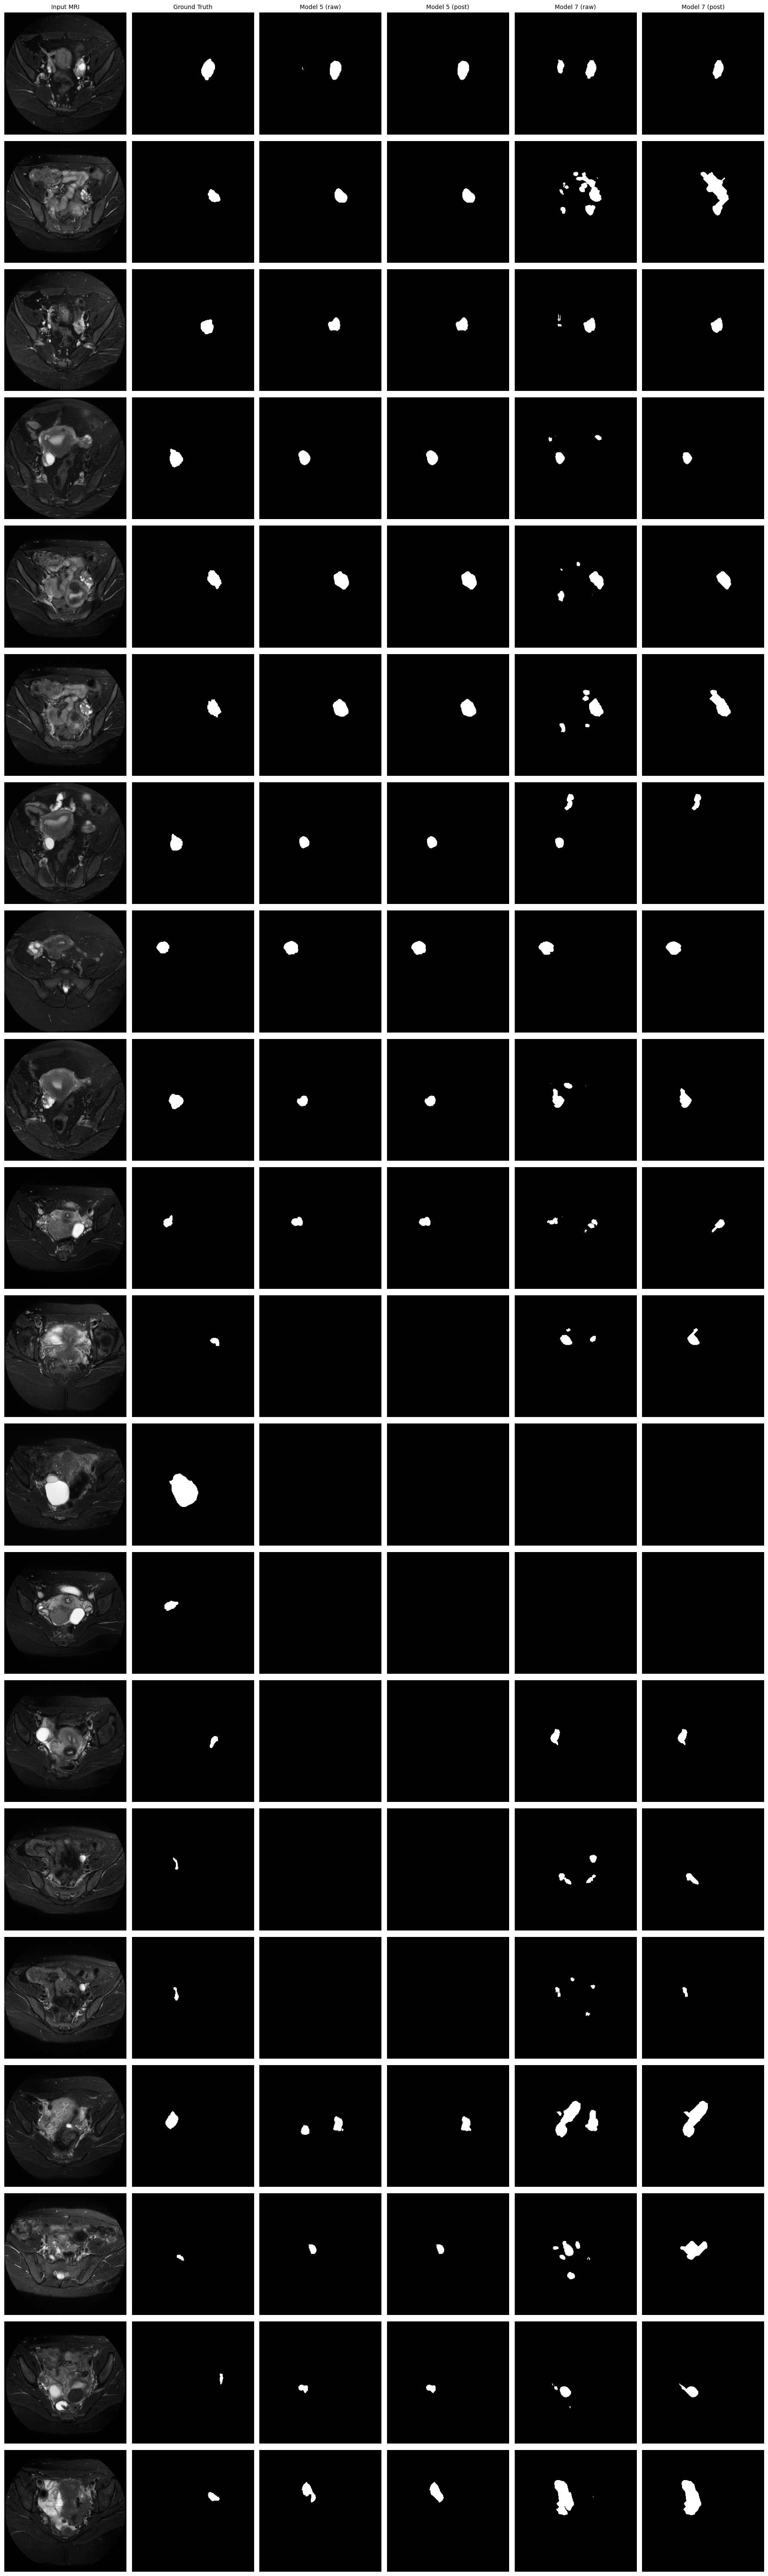

In [8]:
# --- Helper: binary prediction function ---

def predict_binary_mask(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        img_batch = image_tensor.unsqueeze(0).to(device)
        logits = model(img_batch)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
    return preds.squeeze().cpu().numpy().astype(np.uint8)


# --- Qualitative grid: Model 5 vs Model 7 ---

num_rows = len(ranked_indices)
num_cols = 6  # MRI, GT, M5 raw, M5 post, M7 raw, M7 post

fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))
if num_rows == 1:
    axes = np.expand_dims(axes, axis=0)

col_titles = [
    "Input MRI",
    "Ground Truth",
    "Model 5 (raw)",
    "Model 5 (post)",
    "Model 7 (raw)",
    "Model 7 (post)",
]

for col_idx, title in enumerate(col_titles):
    axes[0, col_idx].set_title(title, fontsize=10)

print("Generating Model 5 vs Model 7 qualitative grid...")

for row_idx, dataset_idx in enumerate(ranked_indices):
    img_plain, mask_tensor = val_full_plain[dataset_idx]
    img_prep, _ = val_full_prep[dataset_idx]

    mri_np = img_plain.squeeze().numpy()
    gt_np = mask_tensor.squeeze().numpy().astype(np.uint8)

    # Model 5
    pred5_raw_np = predict_binary_mask(model5, img_prep, device)
    pred5_post_np = postprocess_(pred5_raw_np)

    # Model 7
    pred7_raw_np = predict_binary_mask(model7_best, img_prep, device)
    pred7_post_np = postprocess_(pred7_raw_np)

    row_axes = axes[row_idx]

    row_axes[0].imshow(mri_np, cmap="gray"); row_axes[0].axis("off")
    row_axes[1].imshow(gt_np,  cmap="gray"); row_axes[1].axis("off")
    row_axes[2].imshow(pred5_raw_np,  cmap="gray"); row_axes[2].axis("off")
    row_axes[3].imshow(pred5_post_np, cmap="gray"); row_axes[3].axis("off")
    row_axes[4].imshow(pred7_raw_np,  cmap="gray"); row_axes[4].axis("off")
    row_axes[5].imshow(pred7_post_np, cmap="gray"); row_axes[5].axis("off")

    label = "Easy" if row_idx < k else "Hard"
    row_axes[0].set_ylabel(label, rotation=90, fontsize=9, labelpad=10)

plt.tight_layout()
plt.show()


Generating Model 5 vs Model 7 grid on masked inference images...


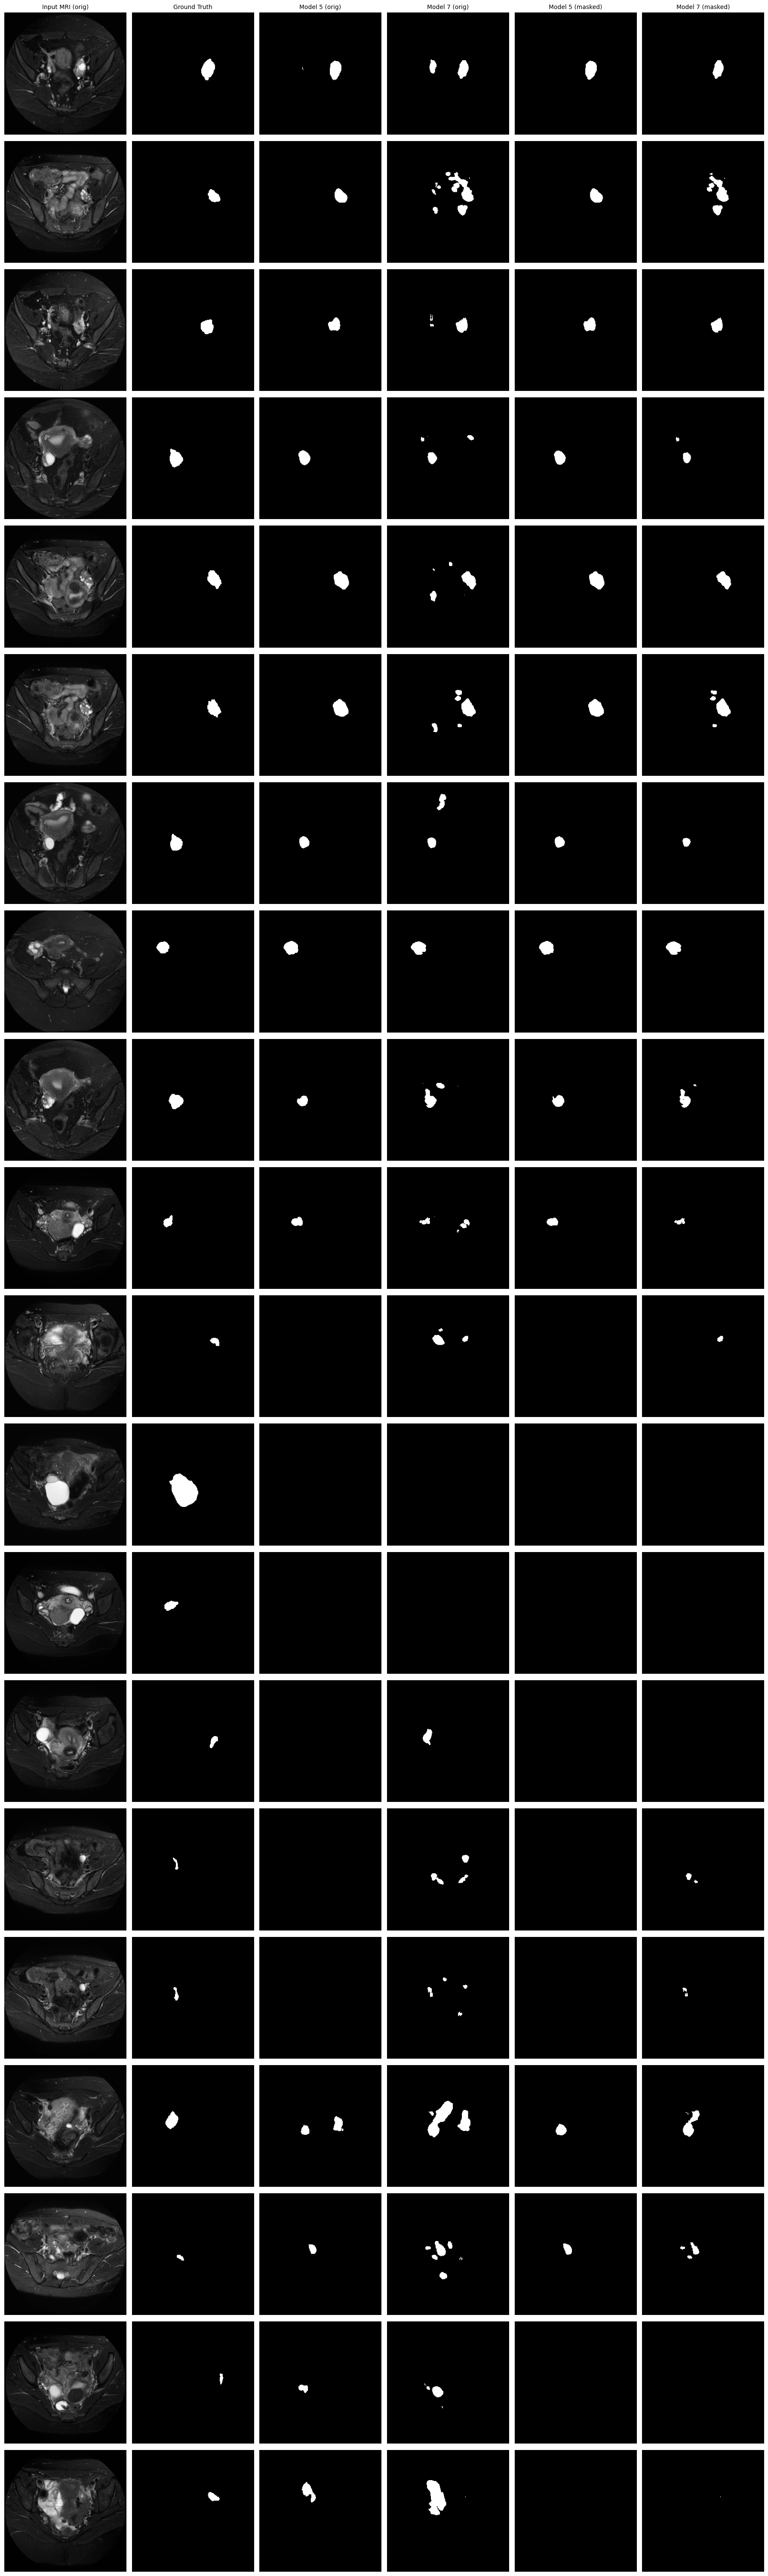

In [9]:
# --- Helper: apply ovary-side masking to an image given its GT mask ---

def mask_image_by_gt(image_tensor, mask_tensor):
    """
    image_tensor: (1, H, W) preprocessed MRI
    mask_tensor:  (1, H, W) binary GT

    Returns a new tensor where the half opposite to the ovary centroid is zeroed out.
    If no ovary in mask, returns the original image.
    """
    image = image_tensor.clone()

    coords = torch.nonzero(mask_tensor[0] > 0, as_tuple=False)
    if coords.numel() == 0:
        # No annotated ovary -> leave unchanged
        return image

    cx = coords[:, 1].float().mean()
    width = image.shape[2]
    mid = width / 2.0

    if cx < mid:
        # Ovary on left -> zero right half
        image[:, :, int(mid):] = 0.0
    else:
        # Ovary on right -> zero left half
        image[:, :, :int(mid)] = 0.0

    return image


# --- Reuse predict_binary_mask from before, or redefine here ---

def predict_binary_mask(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        img_batch = image_tensor.unsqueeze(0).to(device)
        logits = model(img_batch)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
    return preds.squeeze().cpu().numpy().astype(np.uint8)


# --- Qualitative grid: Model 5 vs Model 7 on original vs masked inputs ---

num_rows = len(ranked_indices)
num_cols = 6  # MRI, GT, M5 orig, M7 orig, M5 masked, M7 masked

fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))
if num_rows == 1:
    axes = np.expand_dims(axes, axis=0)

col_titles = [
    "Input MRI (orig)",
    "Ground Truth",
    "Model 5 (orig)",
    "Model 7 (orig)",
    "Model 5 (masked)",
    "Model 7 (masked)",
]

for col_idx, title in enumerate(col_titles):
    axes[0, col_idx].set_title(title, fontsize=10)

print("Generating Model 5 vs Model 7 grid on masked inference images...")

for row_idx, dataset_idx in enumerate(ranked_indices):
    # Original plain image + mask (for display)
    img_plain, mask_tensor = val_full_plain[dataset_idx]
    # Preprocessed image + mask (for inference)
    img_prep, mask_prep = val_full_prep[dataset_idx]

    mri_np = img_plain.squeeze().numpy()
    gt_np = mask_tensor.squeeze().numpy().astype(np.uint8)

    # Original predictions (unmasked input)
    img_prep_orig = img_prep
    pred5_orig_np = predict_binary_mask(model5, img_prep_orig, device)
    pred7_orig_np = predict_binary_mask(model7_best, img_prep_orig, device)

    # Masked input (based on GT)
    img_prep_masked = mask_image_by_gt(img_prep, mask_prep)

    pred5_masked_np = predict_binary_mask(model5, img_prep_masked, device)
    pred7_masked_np = predict_binary_mask(model7_best, img_prep_masked, device)

    row_axes = axes[row_idx]

    # Column 0: original MRI
    row_axes[0].imshow(mri_np, cmap="gray"); row_axes[0].axis("off")
    # Column 1: GT
    row_axes[1].imshow(gt_np, cmap="gray"); row_axes[1].axis("off")
    # Column 2: Model 5 on original
    row_axes[2].imshow(pred5_orig_np, cmap="gray"); row_axes[2].axis("off")
    # Column 3: Model 7 on original
    row_axes[3].imshow(pred7_orig_np, cmap="gray"); row_axes[3].axis("off")
    # Column 4: Model 5 on masked
    row_axes[4].imshow(pred5_masked_np, cmap="gray"); row_axes[4].axis("off")
    # Column 5: Model 7 on masked
    row_axes[5].imshow(pred7_masked_np, cmap="gray"); row_axes[5].axis("off")

    label = "Easy" if row_idx < (len(ranked_indices) // 2) else "Hard"
    row_axes[0].set_ylabel(label, rotation=90, fontsize=9, labelpad=10)

plt.tight_layout()
plt.show()


In [10]:
# === Quantitative comparison: Model 5 vs Model 7 on original vs masked validation images ===

# Helper: apply ovary-side masking based on GT
def mask_image_by_gt(image_tensor, mask_tensor):
    """
    image_tensor: (1, H, W) preprocessed MRI
    mask_tensor:  (1, H, W) binary GT

    Returns a new tensor where the half opposite to the ovary centroid is zeroed out.
    If no ovary in mask, returns the original image.
    """
    image = image_tensor.clone()
    coords = torch.nonzero(mask_tensor[0] > 0, as_tuple=False)
    if coords.numel() == 0:
        return image

    cx = coords[:, 1].float().mean()
    width = image.shape[2]
    mid = width / 2.0

    if cx < mid:
        image[:, :, int(mid):] = 0.0  # ovary left -> zero right
    else:
        image[:, :, :int(mid)] = 0.0  # ovary right -> zero left

    return image


# Helper: evaluate a model on val set with optional masking at inference time
def evaluate_with_optional_mask(model, use_mask: bool):
    model.eval()
    total_loss = 0.0
    total_dice = 0.0
    criterion_ft = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=4/3)

    with torch.no_grad():
        for idx in val_indices:
            img_prep, mask = val_full_prep[idx]  # preprocessed input + GT mask

            if use_mask:
                img_in = mask_image_by_gt(img_prep, mask)
            else:
                img_in = img_prep

            img_batch = img_in.unsqueeze(0).to(device)
            mask_batch = mask.unsqueeze(0).to(device)

            logits = model(img_batch)
            loss = criterion_ft(logits, mask_batch)

            preds = (torch.sigmoid(logits) > 0.5).float()
            d = dice_score(preds, mask_batch)

            total_loss += loss.item()
            total_dice += d.item()

    n = len(val_indices)
    return total_loss / n, total_dice / n


print("Evaluating all combinations...\n")

# Model 5, original val images
loss_5_orig, dice_5_orig = evaluate_with_optional_mask(model5, use_mask=False)
print(f"Model 5 on ORIGINAL val images -> Loss: {loss_5_orig:.4f}, Dice: {dice_5_orig:.4f}")

# Model 7, original val images
loss_7_orig, dice_7_orig = evaluate_with_optional_mask(model7_best, use_mask=False)
print(f"Model 7 on ORIGINAL val images -> Loss: {loss_7_orig:.4f}, Dice: {dice_7_orig:.4f}")

# Model 5, MASKED val images (GT-based masking)
loss_5_mask, dice_5_mask = evaluate_with_optional_mask(model5, use_mask=True)
print(f"Model 5 on MASKED val images   -> Loss: {loss_5_mask:.4f}, Dice: {dice_5_mask:.4f}")

# Model 7, MASKED val images (GT-based masking)
loss_7_mask, dice_7_mask = evaluate_with_optional_mask(model7_best, use_mask=True)
print(f"Model 7 on MASKED val images   -> Loss: {loss_7_mask:.4f}, Dice: {dice_7_mask:.4f}")


Evaluating all combinations...

Model 5 on ORIGINAL val images -> Loss: 0.6575, Dice: 0.3090
Model 7 on ORIGINAL val images -> Loss: 0.6566, Dice: 0.3139
Model 5 on MASKED val images   -> Loss: 0.5733, Dice: 0.3807
Model 7 on MASKED val images   -> Loss: 0.5438, Dice: 0.4001
